# 🚀 Access curated PNW Dataset with SeisBench APIs


![image](https://github.com/niyiyu/PNW-ML/blob/main/figures/README_overview.png?raw=true)

**Author:** Yiyu Ni  
**Goal:** This notebook first demonstrates how to request USGS ComCat and get waveforms. Then we demostrate access the curated PNW seismic dataset with SeisBench APIs.

---

In [1]:
import torch
import obspy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seisbench.data as sbd
import seisbench.generate as sbg

---
## 1. Requst data: USGS earthquake catalog (ComCat)

We start with requesting catalogs from USGS. We can do that though USGS's ComCat web service (https://earthquake.usgs.gov/earthquakes/search/), but here let's query the catalog using USGS's FDSN service through obspy. By creating an obspy FDSN client, we can query event information using the [`client.get_events()`](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_events.html) function.

In [2]:
client_usgs = obspy.clients.fdsn.Client("USGS")

events = client_usgs.get_events(minlatitude=43, 
                                maxlatitude=45,
                                minlongitude=-130, 
                                maxlongitude=-116,
                                minmagnitude=3.0,
                                starttime=obspy.UTCDateTime("2020-01-01"),
                                endtime=obspy.UTCDateTime("2025-01-01"),
                                contributor="uw")
print(events)

7 Event(s) in Catalog:
2023-11-10T20:33:49.570000Z | +44.404, -124.579 | 3.06 ml | manual
2023-04-24T11:42:58.970000Z | +43.492, -127.558 | 3.2  ml | manual
2023-03-08T09:33:06.030000Z | +44.739, -117.270 | 3.03 ml | manual
2022-10-07T12:52:36.010000Z | +44.540, -122.551 | 4.39 ml | manual
2020-09-25T04:26:07.118000Z | +43.397, -127.084 | 3.3  ml | manual
2020-07-21T23:39:16.430000Z | +44.993, -123.842 | 3.17 ml | manual
2020-03-08T06:54:26.188000Z | +43.258, -126.964 | 3.0  ml | manual


We received events with their **event ID, origins, magnitudes, and other metadata.**

In [3]:
print(events[0])

Event:	2023-11-10T20:33:49.570000Z | +44.404, -124.579 | 3.06 ml | manual

	            resource_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/fdsnws/event/1/query?eventid=uw61971621&format=quakeml")
	             event_type: 'earthquake'
	          creation_info: CreationInfo(agency_id='uw', creation_time=UTCDateTime(2024, 5, 10, 23, 15, 7, 800000), version='4')
	    preferred_origin_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/uw61971621/uw/1715382907800/product.xml")
	 preferred_magnitude_id: ResourceIdentifier(id="quakeml:earthquake.usgs.gov/product/origin/uw61971621/uw/1715382907800/product.xml#magnitude")
	                   ---------
	     event_descriptions: 1 Elements
	                origins: 1 Elements
	             magnitudes: 1 Elements


We can also going to the USGS event page using the event id. 

⬇️⬇️**Click the link generated by the cell below**⬇️⬇️

In [4]:
eid = events[0].preferred_origin_id.id.split("/")[3]
print(f"https://earthquake.usgs.gov/earthquakes/eventpage/{eid}/executive")

https://earthquake.usgs.gov/earthquakes/eventpage/uw61971621/executive


One would notice that the event above contains **no phase arrival information**. This is because requesting the arrival information is not supported yet by the USGS FDSN service (otherwise we could add a `includearrivals=True` to the query above).

To retrieve the phase arrival information, we need to extract them from the raw QuakeXML file, which **contains ALL metadata for this event**.

⬇️⬇️Click the link generated by the cell below.⬇️⬇️

In [5]:
quakexml = f"https://earthquake.usgs.gov/fdsnws/event/1/query?eventid={eid}&format=quakeml"
print(quakexml)

https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=uw61971621&format=quakeml


We can load the QuakeXML file directly using [`obspy.read_events()`](https://docs.obspy.org/packages/autogen/obspy.core.event.read_events.html) function, which similarly returns an event object. But this time, we see a `picks` field, which contains a list of picks for this event.

In [6]:
event = obspy.read_events(quakexml)[0]

# show the first 3 picks
for p in event.picks[:3]:
    print("-"*100)
    print(p)

----------------------------------------------------------------------------------------------------
Pick
	       resource_id: ResourceIdentifier(id="quakeml:uw.anss.org/Arrival/UW/16714543")
	              time: UTCDateTime(2023, 11, 10, 20, 33, 58, 320000) [uncertainty=0.06]
	       waveform_id: WaveformStreamID(network_code='UW', station_code='ONAB', channel_code='HNZ', location_code='')
	             onset: 'impulsive'
	          polarity: 'negative'
	   evaluation_mode: 'manual'
	 evaluation_status: 'reviewed'
	     creation_info: CreationInfo(agency_id='UW', creation_time=UTCDateTime(2023, 11, 10, 21, 10, 58))
----------------------------------------------------------------------------------------------------
Pick
	       resource_id: ResourceIdentifier(id="quakeml:uw.anss.org/Arrival/UW/16714548")
	              time: UTCDateTime(2023, 11, 10, 20, 34, 5, 360000) [uncertainty=0.15]
	       waveform_id: WaveformStreamID(network_code='UW', station_code='ONAB', channel_code='HNN', l

We can also try to plot the waveforms for this event. To do that, we create another FDSN client for IRIS (or renamed as EarthScope now). Then we request waveforms for the first picks from the above event.

In [7]:
client_iris = obspy.clients.fdsn.Client("IRIS")

In [8]:
pk = event.picks[0]
pk

Pick
	       resource_id: ResourceIdentifier(id="quakeml:uw.anss.org/Arrival/UW/16714543")
	              time: UTCDateTime(2023, 11, 10, 20, 33, 58, 320000) [uncertainty=0.06]
	       waveform_id: WaveformStreamID(network_code='UW', station_code='ONAB', channel_code='HNZ', location_code='')
	             onset: 'impulsive'
	          polarity: 'negative'
	   evaluation_mode: 'manual'
	 evaluation_status: 'reviewed'
	     creation_info: CreationInfo(agency_id='UW', creation_time=UTCDateTime(2023, 11, 10, 21, 10, 58))

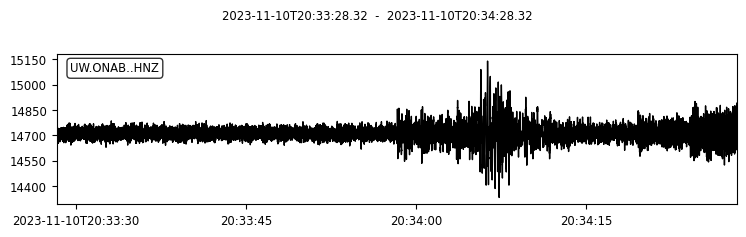

In [9]:
ptime = pk.time
net = pk.waveform_id.network_code
sta = pk.waveform_id.station_code
loc = pk.waveform_id.location_code
cha = pk.waveform_id.channel_code

s = client_iris.get_waveforms(network=net, station=sta, location=loc, channel=cha,
                              starttime=ptime-30, endtime=ptime+30) # get 60-second waveform
s.plot();

### ✏️ Exercise 
1. Pick one event that you are interested (not necessarily from PNW). Get its event ID and check its event page.
2. Query it from USGS ComCat using `obspy.get_events()`. 
3. Get its phase arrival information by reading its QuakeXML file using `obspy.read_events()`.
4. Get waveforms make plots for its phase picks using `client_iris.get_waveforms()`.

---
## 2. Use the curated PNW dataset with SeisBench API

The PNW dataset is made by the waveform file (in `hdf5` format, sometime also called `h5`) and the perspective metadata file (in `csv` format). See the structure in the `data/pnwml` folder with two small datasets (i.e., **miniPNW** and **mesoPNW**).

🚀 Read more about SeisBench data format: https://seisbench.readthedocs.io/en/stable/pages/data_format.html

In [10]:
# replace the path with where your dataset is
! tree -lh ../data/pnwml

[ 160]  ../data/pnwml
├── [ 128]  mesoPNW
│   ├── [4.7M]  metadata.csv
│   └── [6.3G]  waveforms.hdf5
└── [ 160]  miniPNW
    ├── [424K]  metadata.csv
    └── [640M]  waveforms.hdf5

2 directories, 4 files


The `waveforms.hdf5` contains arrays of seismograms. We can see arrays are grouped into 10 buckets. The file also contains very few metadata like the `component_order` for three-component seismogram.

🛠️ `h5dump` is a useful tool to check the hierarchical structure of this HDF5 file.

In [11]:
# replace the path with where your dataset is
! h5dump -n ../data/pnwml/mesoPNW/waveforms.hdf5

HDF5 "../data/pnwml/mesoPNW/waveforms.hdf5" {
FILE_CONTENTS {
 group      /
 group      /data
 dataset    /data/bucket1
 dataset    /data/bucket10
 dataset    /data/bucket2
 dataset    /data/bucket3
 dataset    /data/bucket4
 dataset    /data/bucket5
 dataset    /data/bucket6
 dataset    /data/bucket7
 dataset    /data/bucket8
 dataset    /data/bucket9
 group      /data_format
 dataset    /data_format/component_order
 }
}


The `metadata.csv` represents a table of metadata for each data sample. It also documents where to locate the waveform. We will have a better view of this table later.

In [12]:
# replace the path with where your dataset is
! head -n 5 ../data/pnwml/mesoPNW/metadata.csv

event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,preferred_source_magnitude,preferred_source_magnitude_type,preferred_source_magnitude_uncertainty,source_depth_uncertainty_km,source_horizontal_uncertainty_km,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,trace_S_arrival_uncertainty_s,trace_P_arrival_uncertainty_s,trace_P_polarity,trace_S_onset,trace_P_onset,trace_snr_db,source_type_pnsn_label,source_local_magnitude,source_local_magnitude_uncertainty,source_duration_magnitude,source_duration_magnitude_uncertainty,source_hand_magnitude,trace_missing_channel,trace_has_offset,bucket,tindex
uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.52,earthquake,14.907,2.1,md,0.03,1.68,0.694,UW,BH,GNW,--,47.564,-122.825,220.0,"bucket4$0,:3,:15001",100,2002-10-03T01

We can load the dataset using `seisbench.data` as a `WaveformDataset` class. 

In [13]:
# replace the path with where your dataset is
dataset = sbd.WaveformDataset("../data/pnwml/mesoPNW/", component_order="ENZ")

print(f"The dataset contains {len(dataset)} samples.")

2025-05-11 22:22:46,866 | seisbench | WARNING | Dimension order not specified in data set. Assuming CW.


The dataset contains 18640 samples.


Let's make the plot of the PNW dataset: events and stations.

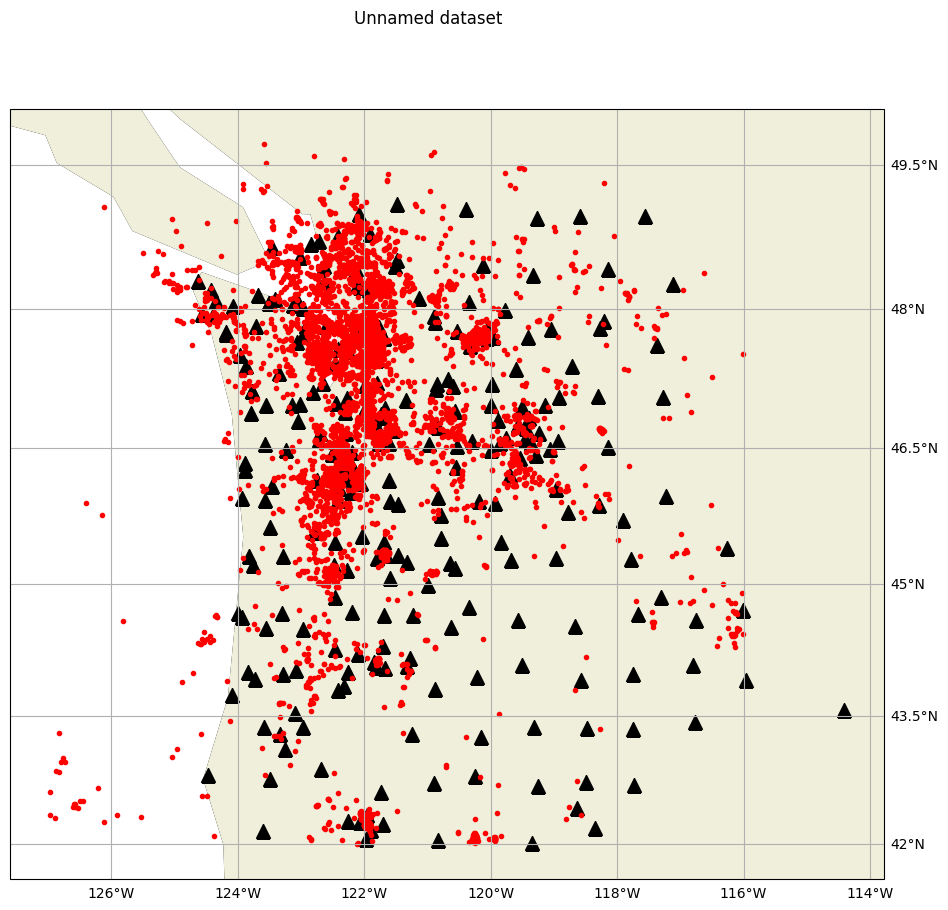

In [14]:
dataset.plot_map();

The metadata can be accessed by the `.metadata` attribute of the dataset as a `pd.DataFrame` object. Each row here represents one sample (one 3C waveforms).

In [15]:
pd.set_option('display.max_columns', None) # show all columns
meta = dataset.metadata
meta.head()

,index,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,preferred_source_magnitude,preferred_source_magnitude_type,preferred_source_magnitude_uncertainty,source_depth_uncertainty_km,source_horizontal_uncertainty_km,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,trace_S_arrival_uncertainty_s,trace_P_arrival_uncertainty_s,trace_P_polarity,trace_S_onset,trace_P_onset,trace_snr_db,source_type_pnsn_label,source_local_magnitude,source_local_magnitude_uncertainty,source_duration_magnitude,source_duration_magnitude_uncertainty,source_hand_magnitude,trace_missing_channel,trace_has_offset,bucket,tindex,trace_chunk,trace_component_order
0,0,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.1,md,0.03,1.68,0.694,UW,BH,GNW,--,47.564,-122.825,220.0,"bucket4$0,:3,:15001",100.0,2002-10-03T01:55:59.530000Z,8097,6733,0.04,0.02,undecidable,NaN,NaN,6.135|3.065|11.766,eq,NaN,NaN,2.1,0.03,NaN,0,1,4,0,,ENZ
1,1,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.1,md,0.03,1.68,0.694,UW,EH,RPW,--,48.448,-121.515,850.0,"bucket9$0,:3,:15001",100.0,2002-10-03T01:55:59.530000Z,7258,6238,0.04,0.01,undecidable,NaN,NaN,nan|nan|22.583,eq,NaN,NaN,2.1,0.03,NaN,2,0,9,0,,ENZ
2,2,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.1,md,0.03,1.68,0.694,UW,BH,SQM,--,48.074,-123.048,45.0,"bucket4$1,:3,:15001",100.0,2002-10-03T01:55:59.530000Z,7037,6113,0.08,0.04,undecidable,NaN,NaN,1.756|3.057|3.551,eq,NaN,NaN,2.1,0.03,NaN,0,1,4,1,,ENZ
3,3,uw10564613,2002-10-03T01:56:49.530000Z,48.553,-122.520,earthquake,14.907,2.1,md,0.03,1.68,0.694,UW,EH,MCW,--,48.679,-122.833,693.0,"bucket7$0,:3,:15001",100.0,2002-10-03T01:55:59.530000Z,5894,5442,0.04,0.01,negative,NaN,NaN,nan|nan|27.185,eq,NaN,NaN,2.1,0.03,NaN,2,0,7,0,,ENZ
4,4,uw10568748,2002-09-26T07:00:04.860000Z,48.481,-123.133,earthquake,22.748,2.9,md,0.03,0.91,0.672,UW,HH,SP2,--,47.556,-122.249,30.0,"bucket3$0,:3,:15001",100.0,2002-09-26T06:59:14.860000Z,8647,6948,0.04,0.01,negative,NaN,NaN,10.881|17.107|2.242,eq,NaN,NaN,2.9,0.03,NaN,0,1,3,0,,ENZ


For each sample, we can get its waveform and metadata using `dataset.get_sample()`.

{'index': 50, 'event_id': 'uw10578728', 'source_origin_time': '2002-08-31T01:23:39.420000Z', 'source_latitude_deg': 47.419, 'source_longitude_deg': -120.078, 'source_type': 'earthquake', 'source_depth_km': 11.774, 'preferred_source_magnitude': 2.0, 'preferred_source_magnitude_type': 'md', 'preferred_source_magnitude_uncertainty': 0.04, 'source_depth_uncertainty_km': 1.08, 'source_horizontal_uncertainty_km': 0.68, 'station_network_code': 'UW', 'station_channel_code': 'EH', 'station_code': 'EPH', 'station_location_code': '--', 'station_latitude_deg': 47.356, 'station_longitude_deg': -119.597, 'station_elevation_m': 661.0, 'trace_name': 'bucket3$4,:3,:15001', 'trace_sampling_rate_hz': 100.0, 'trace_start_time': '2002-08-31T01:22:49.420000Z', 'trace_S_arrival_sample': 6119, 'trace_P_arrival_sample': 5642, 'trace_S_arrival_uncertainty_s': 0.06, 'trace_P_arrival_uncertainty_s': 0.04, 'trace_P_polarity': 'undecidable', 'trace_S_onset': nan, 'trace_P_onset': nan, 'trace_snr_db': 'nan|nan|21.87

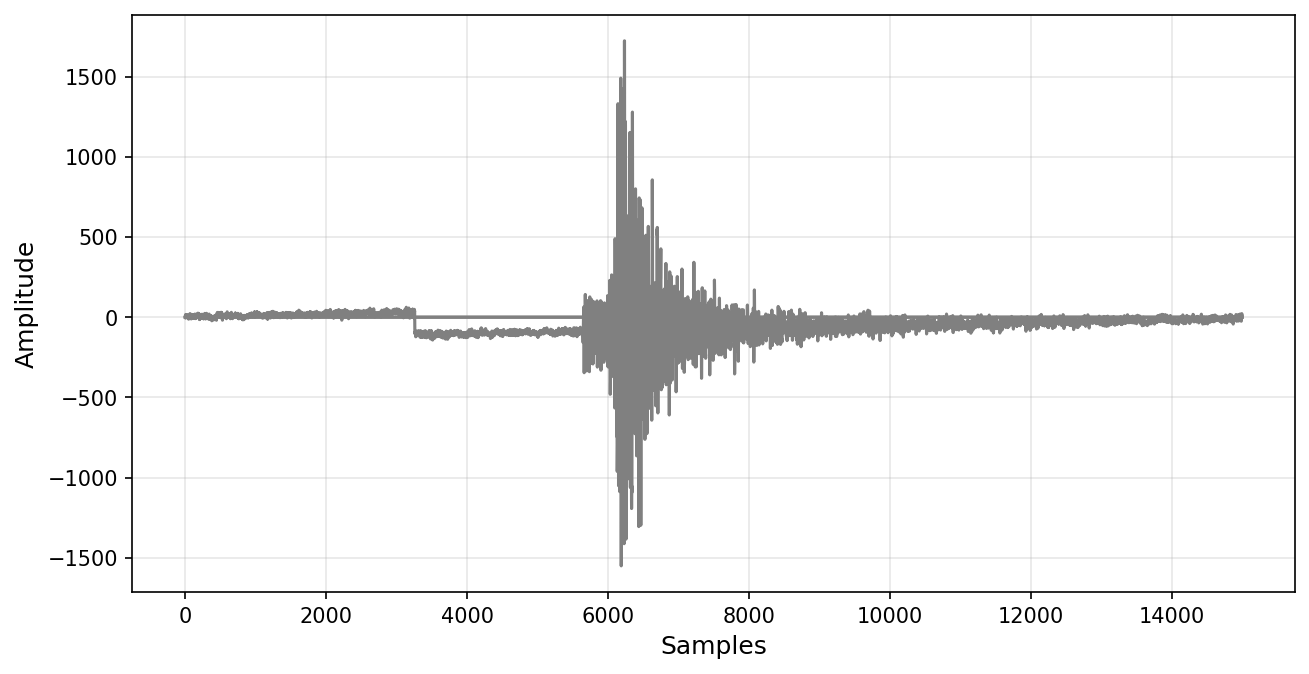

In [16]:
idx = 50
waveform_sp, metadata_sp = dataset.get_sample(idx) # returns waveforms and metadata for that sample
print(metadata_sp)

plt.figure(figsize = (10, 5), dpi = 150)
plt.plot(waveform_sp.T, c='gray')
plt.xlabel("Samples", fontsize = 12)
plt.ylabel("Amplitude", fontsize = 12)
plt.grid(True, alpha=0.3)

---
## 3. SeisBench data augmentataion APIs

A generator is employed as a dataset wrapper, where users specify APIs for data pre-processing and augmentation. These are several augmentation methods implemented in the cell below.

- sbg.Filter
- sbg.WindowAroundSample
- sbg.RandomWindow
- sbg.Normalize
- sbg.DetectionLabeller
- sbg.ProbabilisticLabeller

🚀 See https://seisbench.readthedocs.io/en/latest/pages/documentation/generate.html for all supported augmentation methods.

In [17]:
generator = sbg.GenericGenerator(dataset)

phase_dict = {"trace_P_arrival_sample": "P",
              "trace_S_arrival_sample": "S"}

augmentations = [
    sbg.Filter(4, 0.1, "highpass", forward_backward=True),
    sbg.WindowAroundSample(list(phase_dict.keys()), 
                           samples_before=5000, 
                           windowlen=10000, 
                           selection="first", 
                           strategy="pad"),
    sbg.RandomWindow(windowlen=6000),
    sbg.Normalize(demean_axis=-1, 
                  amp_norm_axis=-1, 
                  amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.DetectionLabeller("trace_P_arrival_sample", 
                          "trace_S_arrival_sample", 
                          factor=1.,
                          dim=0, 
                          key=('X', 'y2')),
    sbg.ProbabilisticLabeller(label_columns=phase_dict, 
                              shape='triangle', 
                              sigma=10, 
                              dim=0, 
                              key=('X', 'y1'))
]
generator.add_augmentations(augmentations)
print(generator)

<class 'seisbench.generate.generator.GenericGenerator'> with 7 augmentations:
 1.	Filter (highpass, order=4, frequencies=0.1, analog=False, forward_backward=True, axis=-1)
 2.	WindowAroundSample (metadata_keys=['trace_P_arrival_sample', 'trace_S_arrival_sample'], samples_before=5000, selection=first)
 3.	RandomWindow (low=None, high=None)
 4.	Normalize (Demean (axis=-1), Amplitude normalization (type=peak, axis=-1))
 5.	ChangeDtype (dtype=<class 'numpy.float32'>, key=('X', 'X'))
 6.	DetectionLabeller (label_type=multi_class, dim=0)
 7.	ProbabilisticLabeller (label_type=multi_class, dim=0)



**A generator is indexable.** You can use an index to access a specific data sample, and plot the waveforms.

In [18]:
idx = 0
sp = generator[idx]
for k, v in sp.items():
    print("-"*100)
    print({k: v})
    print({k: v.shape})

----------------------------------------------------------------------------------------------------
{'X': array([[ 0.00939505,  0.01786446,  0.02163365, ..., -0.27010265,
        -0.3241703 , -0.31755853],
       [ 0.12427884,  0.11992501,  0.11597473, ..., -0.17028928,
        -0.17306767, -0.19574937],
       [ 0.07414731,  0.07549424,  0.07701008, ..., -0.29369366,
        -0.19150622, -0.10243223]], dtype=float32)}
{'X': (3, 6000)}
----------------------------------------------------------------------------------------------------
{'y2': array([[0., 0., 0., ..., 1., 1., 1.]])}
{'y2': (1, 6000)}
----------------------------------------------------------------------------------------------------
{'y1': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])}
{'y1': (3, 6000)}


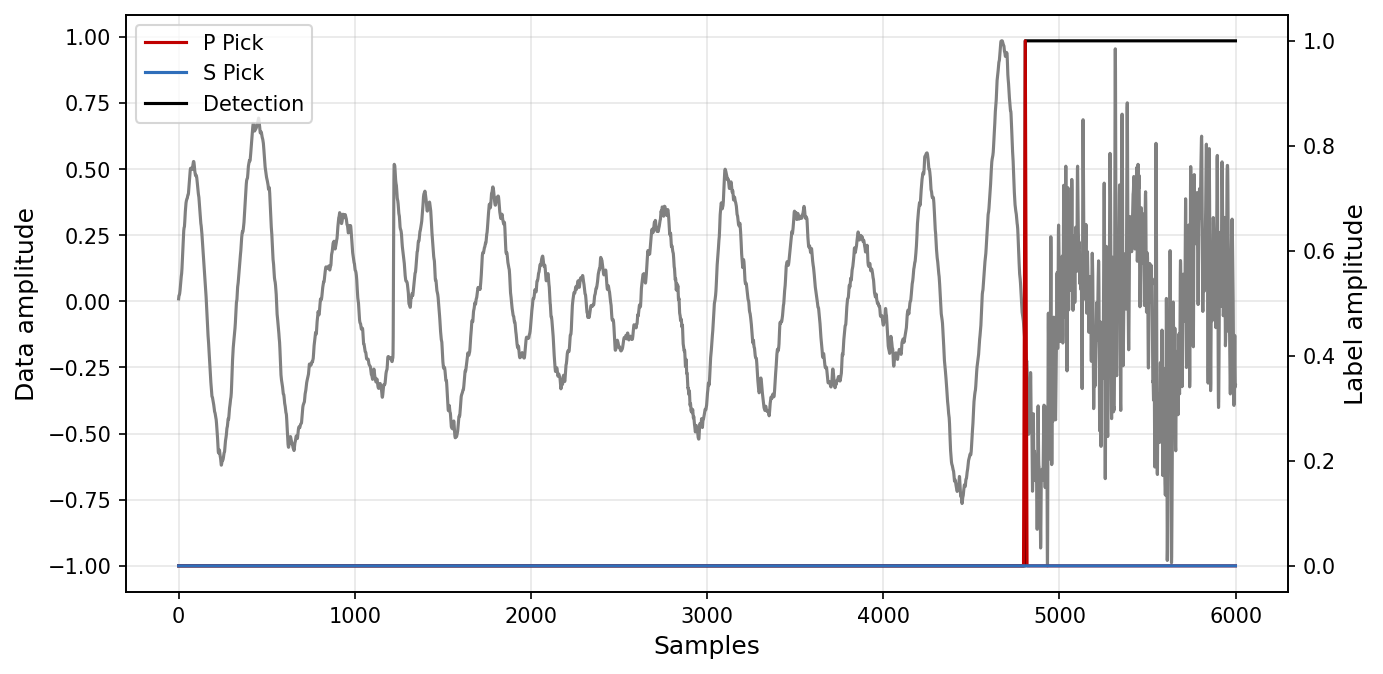

In [19]:
plt.figure(figsize = (10, 5), dpi = 150)
plt.plot(sp['X'][0, :].T, c='gray')
plt.xlabel("Samples", fontsize = 12)
plt.ylabel("Data amplitude", fontsize = 12)
plt.grid(True, alpha=0.3)

ax = plt.gca().twinx()
ax.plot(sp['y1'][0, :].T, label = "P Pick", c="#c00000")
ax.plot(sp['y1'][1, :].T, label = "S Pick", c="#2f6eba")
ax.plot(sp['y2'][0, :].T, label = "Detection", color='k', zorder=-1)
plt.ylabel("Label amplitude", fontsize = 12)

plt.legend(loc = 'upper left')

---
## 4. Loading data in batch

Machine Learning model training usually load data in batch. The `generator` object can be wrapped by the pytorch API `torch.utils.data.DataLoader` to generate samples in batch. See examples below that creates a data loader and return 256 samples in batch.

In [20]:
batch_size = 256
loader = torch.utils.data.DataLoader(generator, 
                    batch_size=batch_size, shuffle=True, num_workers=0)

See the changes in the **array size** as well as the **array type**.

In [21]:
for i in loader:
    for k, v in i.items():
        print("-"*100)
        print({k: v})
        print({k: v.shape})
    break

----------------------------------------------------------------------------------------------------
{'X': tensor([[[ 8.0843e-03,  1.0096e-01,  1.6344e-01,  ...,  3.5261e-01,
           3.5204e-01,  3.6015e-01],
         [ 1.3303e-01,  1.4858e-01,  1.3714e-01,  ...,  2.1463e-02,
           4.0391e-02,  4.7062e-02],
         [-2.3770e-01, -2.9576e-01, -3.3103e-01,  ...,  6.2313e-02,
           5.9363e-02,  6.3836e-02]],

        [[-1.2968e-02, -2.6475e-02, -3.7075e-02,  ..., -1.3206e-01,
          -1.3549e-01, -1.3889e-01],
         [-1.0512e-01, -1.0972e-01, -1.1468e-01,  ...,  2.0600e-01,
           2.0425e-01,  2.0141e-01],
         [ 2.6311e-01,  2.5464e-01,  2.4623e-01,  ..., -1.7793e-01,
          -1.7087e-01, -1.6317e-01]],

        [[ 3.0123e-04, -3.4031e-03, -5.8279e-03,  ...,  1.7600e-01,
           1.7158e-01,  1.6851e-01],
         [-7.7020e-03, -6.3803e-03, -4.7197e-03,  ...,  3.9370e-01,
           3.9202e-01,  3.9235e-01],
         [-2.0847e-01, -2.0600e-01, -2.0458e-01, 

---
## Reference

* https://github.com/niyiyu/PNW-ML
* Ni, Y., Hutko, A., Skene, F., Denolle, M., Malone, S., Bodin, P., Hartog, R., & Wright, A. (2023). Curated Pacific Northwest AI-ready Seismic Dataset. Seismica, 2(1).
* https://github.com/seisbench/seisbench
* Woollam, J., Münchmeyer, J., Tilmann, F., Rietbrock, A., Lange, D., Bornstein, T., ... & Soto, H. (2022). SeisBench—A toolbox for machine learning in seismology. Seismological Society of America, 93(3), 1695-1709.